# Enhancing Civic Engagement and Accountability of Kenyan Parliament Using Topic Modeling

- Utilise topic modelling techniques to automatically identify key themes and issues discussed in parliamentary debates  
- Compare and contrast the topics discussed in different parliamentary sessions to identify changes and trends in the legislative agenda  



In [74]:
# !pip install pyLDAvis nltk wordcloud spacy download 
# !python -m spacy download en_core_web_lg

# Scrape Data 

In [75]:
# from urllib.request import urlopen
# import pandas as pd
# import re
# from bs4 import BeautifulSoup
# from urllib.request import urlopen
# import numpy 
# import time
# import csv

In [76]:
# url = "https://info.mzalendo.com/hansard/"
# page = urlopen(url)
# html = page.read().decode("utf-8")
# soup = BeautifulSoup(html, "html.parser")

# sessions = soup.select('ul.listing > li')
# results = []
# count = 0

# #Generate time string
# timestr = time.strftime("%Y-%m-%d_%H-%M-%S")

# with open(f'mzalendo_hansard-{timestr}.csv', 'a') as f:
#     writer = csv.writer(f) # Open file before creating
#     for session in sessions:
#         link = session.a['href']
#         session_id = session.text

#         session_date = re.search(r'\d*-*\d*-\d*', session_id).group().strip()
#         session_chamber = re.search(r'^\D*\s', session_id).group().strip()

#         if '2006' in session_date:
#           print("I reached 2006")
#           break

#         url = f'https://info.mzalendo.com{link}'
#         print(url)
#         page = urlopen(url)
#         html = page.read().decode("utf-8")
#         soup = BeautifulSoup(html, "html.parser")

#         speeches = soup.find_all('li',class_='speech')



#         for speech in speeches:

#           polititian = speech.strong.text.strip()
#           work = speech.p.text.strip()

#           writer.writerow([session_chamber,session_date,polititian,work])
#           results.append([session_chamber,session_date,polititian,work])
#         time.sleep(5) #This prevents from being locked oout of the system
# results[1:5]


In [77]:
import multiprocessing

multiprocessing.cpu_count()

8

## Save scarped data to csv

In [78]:
# import csv
# import numpy as np
# arr = np.asarray(results)
# with open('sample.csv', 'w') as f:
#     mywriter = csv.writer(f, delimiter=',')
#     mywriter.writerows(arr)  

# Pre-analysis 

## Load Libraries

In [79]:
from urllib.request import urlopen
# import pandas as pd
import dask.dataframe as pd 
import re
from bs4 import BeautifulSoup
from urllib.request import urlopen
import numpy 
import time

## Load Dataset

The dataset is from [Mzaledo.com](https://info.mzalendo.com).

In [80]:
# url = 'https://raw.githubusercontent.com/skngetich/randomdataset/main/kenyan_hansard_mzalendo.csv'
url = 'mzalendo_hansard-2023-02-17_19-30-04.csv'

df = pd.read_csv(url,names=['chamber','session_date','polititian','speech'])
df.head()

,chamber,session_date,polititian,speech
0,Senate,2023-02-15,Hon. Kingi,"Clerk, do we have quorum?"
1,Senate,2023-02-15,Hon. Kingi,Good. Let us proceed.
2,Senate,2023-02-15,Hon. Kingi,"Hon. Senators, I hereby report to the Senate t..."
3,Senate,2023-02-15,Hon. Kingi,"Hon. Senators, the salient issues raised in th..."
4,Senate,2023-02-15,Hon. Kingi,The electronic version of the Senate Hansard R...


## Check the number of rows 

In [81]:
len(df)

755828

Check the datatypes for the respective colums

In [82]:
# convert Ses to datetime pandas
df['session_date'] = pd.to_datetime(df['session_date'])
df.dtypes

chamber                 object
session_date    datetime64[ns]
polititian              object
speech                  object
dtype: object

In [83]:
df.dtypes

chamber                 object
session_date    datetime64[ns]
polititian              object
speech                  object
dtype: object

In [84]:
df.head()

,chamber,session_date,polititian,speech
0,Senate,2023-02-15,Hon. Kingi,"Clerk, do we have quorum?"
1,Senate,2023-02-15,Hon. Kingi,Good. Let us proceed.
2,Senate,2023-02-15,Hon. Kingi,"Hon. Senators, I hereby report to the Senate t..."
3,Senate,2023-02-15,Hon. Kingi,"Hon. Senators, the salient issues raised in th..."
4,Senate,2023-02-15,Hon. Kingi,The electronic version of the Senate Hansard R...


In [85]:
# df.polititian.value_counts()[1:20].plot.bar()

In [86]:
# df.groupby([df.chamber,df.session_date.dt.year]).count()
# df[df.chamber == 'National Assembly'].groupby([df.session_date.dt.year])['session_date'].count()



In [87]:
df.dtypes

chamber                 object
session_date    datetime64[ns]
polititian              object
speech                  object
dtype: object

# Exploratory Data analyisis

# Data Cleaning

In [88]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [89]:
# import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt


#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Check for missing values

In [90]:
# Returns the rows that have Nan values in the speech column
df[df.speech.isnull()].compute()

,chamber,session_date,polititian,speech
17112,Senate,2022-10-04,Hon. Kingi,NaN
35223,National Assembly,2022-02-09,Millie Grace Akoth Odhiambo Mabona,NaN
95785,National Assembly,2021-02-18,Paul Simba Arati,NaN
96458,National Assembly,2021-02-18,Paul Simba Arati,NaN
102026,Senate,2020-12-17,Hon. Mike Mbuvi Sonko,NaN
104194,Senate,2020-12-16,Mr. Harrison Kinyanjui,NaN
104658,Senate,2020-12-16,Mr. Ashioya Biko Brian,NaN
84945,National Assembly,2018-11-15,James Onyango Oyoo,NaN
5970,National Assembly,2014-10-28,Moses Kipkemboi Cheboi,NaN
96406,National Assembly,2013-05-15,Moses Kipkemboi Cheboi,NaN


Since there are two missing values. The strategy is to drop the missing values

In [91]:
df=df.dropna(subset=['speech']).compute()

In [92]:
# Returns the rows that have Nan values in the speech column
df[df.speech.isnull()]

,chamber,session_date,polititian,speech


## Remove symbols, numbers and URL links

In [93]:
df['speech']

0                                 Clerk, do we have quorum?
1                                     Good. Let us proceed.
2         Hon. Senators, I hereby report to the Senate t...
3         Hon. Senators, the salient issues raised in th...
4         The electronic version of the Senate Hansard R...
                                ...                        
148900    March 20, 2007 PARLIAMENTARY DEBATES 7 Mr. Spe...
148901    There are also several other Bills and policy ...
148902    Mr. Speaker, Sir, I beg to move the following ...
148903    Hon. Members, we have concluded the business f...
148904    Hon. Members, that concludes our business for ...
Name: speech, Length: 755812, dtype: object

In [94]:
type(df)

pandas.core.frame.DataFrame

In [95]:
df['speech'] = df['speech'].apply(lambda x: x.lower())
df['speech'] = df['speech'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['speech'] = df['speech'].apply(lambda x: re.sub(r'\d+', '', x))
df['speech'] = df['speech'].apply(lambda x: re.sub(r'https?://\S+', '', x))
df['speech'] = df['speech'].apply(lambda x: re.sub(r'\d+', '', x))
df['speech'] = df['speech'].apply(lambda x: re.sub(r'#\S+', '', x))
df["speech"] = df['speech'].replace(r'\r', ' ', regex=True)
df["speech"] = df['speech'].replace(r'\n', ' ', regex=True)


In [96]:
# !pip install swifter
import swifter

In [97]:
df= df.groupby([df.chamber,df.session_date])['speech'].apply(','.join).reset_index()

## Remove non-english words

In [98]:
## removing non english words
nltk.download('words')
english_words = set(nltk.corpus.words.words())

# Define a function that takes in a string and returns a list of English words
def filter_english(text):
    words = text.split()
    english_words_x = [word for word in words if word in english_words]
    return ' '.join(english_words_x)


# print(filter_english('mimi na Kazi I am good')) #Testing the functions
# # Apply the function to the column to remove non-English words
df["speech"] = df["speech"].apply(filter_english)

[nltk_data] Downloading package words to /home/jovyan/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Remove Stopwords

In [99]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
  
example_sent = """This is a sample sentence,
                  showing off the stop words filtration."""

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    
  word_tokens = word_tokenize(text)
  # converts the words in word_tokens to lower case and then checks whether 
  #they are present in stop_words or not
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  #with no lower case conversion
  filtered_sentence = []
    
  for w in word_tokens:
      if w not in stop_words:
          filtered_sentence.append(w)
  return " ".join(filtered_sentence)
  
print(remove_stopwords(example_sent))

This sample sentence , showing stop words filtration .


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
df.speech = df.speech.swifter.apply(remove_stopwords)

Pandas Apply:   0%|          | 0/2082 [00:00<?, ?it/s]

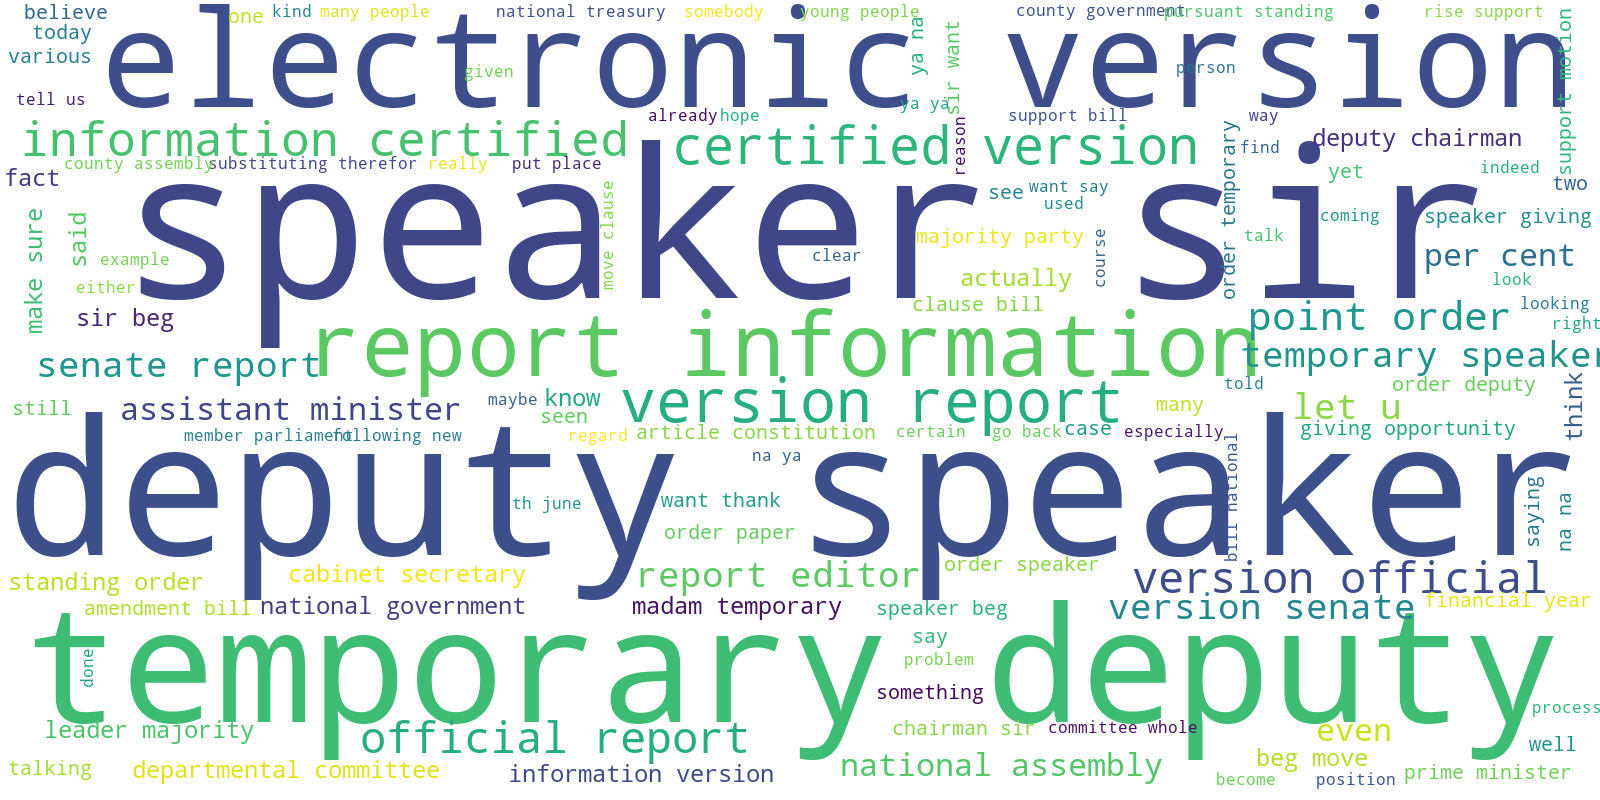

In [101]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',scale=4)
# Join the different processed titles together.
long_string = ','.join(list(df['speech'].values))
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

`hon`, `people`,`will`,`Hansard` are the popular words spoken in the legislature

In [102]:
df['speech'] = df['speech'].apply(lambda x: re.sub(r'hon\s', '', x))


## Lemmatize

In [103]:
# !python -m spacy download en_core_web_sm

In [104]:
import dask.dataframe as dd
dd

<module 'dask.dataframe' from '/opt/conda/lib/python3.10/site-packages/dask/dataframe/__init__.py'>

In [105]:
# Load spacy pipeline
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Function lemmatizes nouns,adjectives,verbs and adverbs
def lemmatization(text, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    """
    Parameter:
    text -  legislative speeches of the day
    
    Returns:
    A list of lemmetized words
    """
    doc = nlp(text)
    new_text = " "
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text += token.lemma_
            new_text += " " 
    return new_text.strip()

In [106]:
gg= "THis is not the world we need"

lemmatization(gg)

'world need'

In [107]:
df.speech = df.speech.apply(lemmatization)

In [108]:
df.speech

0       excellency call spiritual offer new excellency...
1       speaker move follow motion debate motion presi...
2       proceed motion seek ministerial point order sp...
3       speaker national security follow question priv...
4       speaker give follow adoption report assembly l...
                              ...                        
2077    clerk confirm indeed speaker go order administ...
2078    establish indeed quorum clerk proceed call fir...
2079    let proceed first speaker senator help navigat...
2080    pleasure privilege welcome second session inde...
2081    clerk let hereby report concern first choice r...
Name: speech, Length: 2082, dtype: object

In [109]:
# creates a deep copy of the dataframe
df2 = df.copy()

def gen_words(text):
   return gensim.utils.simple_preprocess(text, deacc=True)
  

df2['speech'] = df2['speech'].swifter.apply(gen_words)


Pandas Apply:   0%|          | 0/2082 [00:00<?, ?it/s]

In [110]:
df2.speech

0       [excellency, call, spiritual, offer, new, exce...
1       [speaker, move, follow, motion, debate, motion...
2       [proceed, motion, seek, ministerial, point, or...
3       [speaker, national, security, follow, question...
4       [speaker, give, follow, adoption, report, asse...
                              ...                        
2077    [clerk, confirm, indeed, speaker, go, order, a...
2078    [establish, indeed, quorum, clerk, proceed, ca...
2079    [let, proceed, first, speaker, senator, help, ...
2080    [pleasure, privilege, welcome, second, session...
2081    [clerk, let, hereby, report, concern, first, c...
Name: speech, Length: 2082, dtype: object


Notice topic 1 has a words that would not be categorised as topics.
This is a problem since the model is not able to clulster words correctly.

A solution is to use `Bigrams/Digrams` and `TF-IDF`

## BIGRAMS and DIGRAMS

n-grams i.e bi-grams(2 words) and tri-grams(3 words)  are combined individia word that form a semantic meaning.

In [111]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df2.speech, min_count=5, threshold=70) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df2.speech], threshold=70)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


def make_bigrams(text):

    return(bigram_mod[text])
def make_trigrams(text):
  return(trigram_mod[text])

# print(make_bigrams(df2.speech[0])) # for testing
df2.speech = df2.speech.apply(make_bigrams)
df2.speech = df2.speech.apply(make_trigrams)

In [112]:
ngrams = []
for doc in df2.speech:
  for text in doc:
    if "_" in text:
      ngrams.append(text)
total_ngrams = set(ngrams)
print(f"Total number of ngrams is {len(total_ngrams)}")
# total_ngrams

Total number of ngrams is 4338


In [113]:
# df2.speech[60]

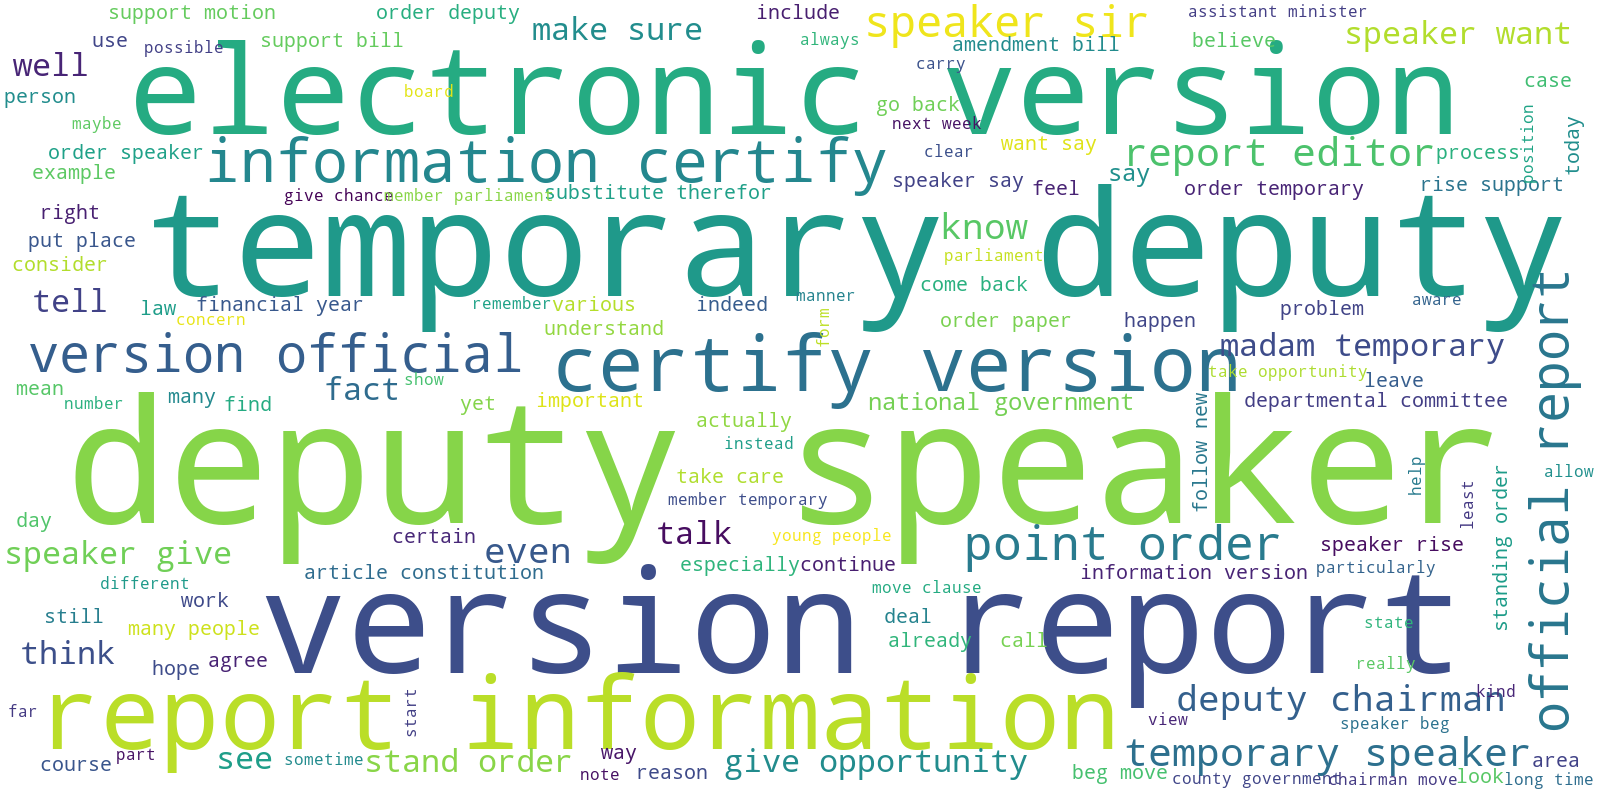

In [114]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',scale=4)
# Join the different processed titles together.
long_string = ','.join(list(df['speech'].values))
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [115]:
def gen_corpus(df_series):
  id2word = corpora.Dictionary(df_series)
  
  id2word.filter_extremes(no_below=5, no_above=0.3, keep_n=None)  # use Dictionary to remove un-relevant tokens
  id2word.compactify()

  corpus = []
  for text in df_series:
      new = id2word.doc2bow(text)
      corpus.append(new)
  return [corpus,id2word]

 

In [116]:
corpus,id2word = gen_corpus(df2.speech)

In [117]:
#TF IDF

from gensim.models import TfidfModel

tfidf  = TfidfModel(corpus,id2word)

low_value = 0.03

words = []
words_missing_tfidf = []

for i in range(0,len(corpus)):
  bow = corpus[i]
  low_value_words = []
  tfidf_ids = [id for id,value in tfidf[bow]]
  bow_ids = [id for id, value in bow]
  low_value_words = [id for id, value in tfidf[bow] if value < low_value]
  drops = low_value_words+words_missing_tfidf

  for item in drops:
    words.append(id2word[item])
  words_missing_tfidf = [id for id in  bow_ids if id not in tfidf_ids]

  new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_tfidf]
  corpus[i] = new_bow

Pandas Apply:   0%|          | 0/2082 [00:00<?, ?it/s]

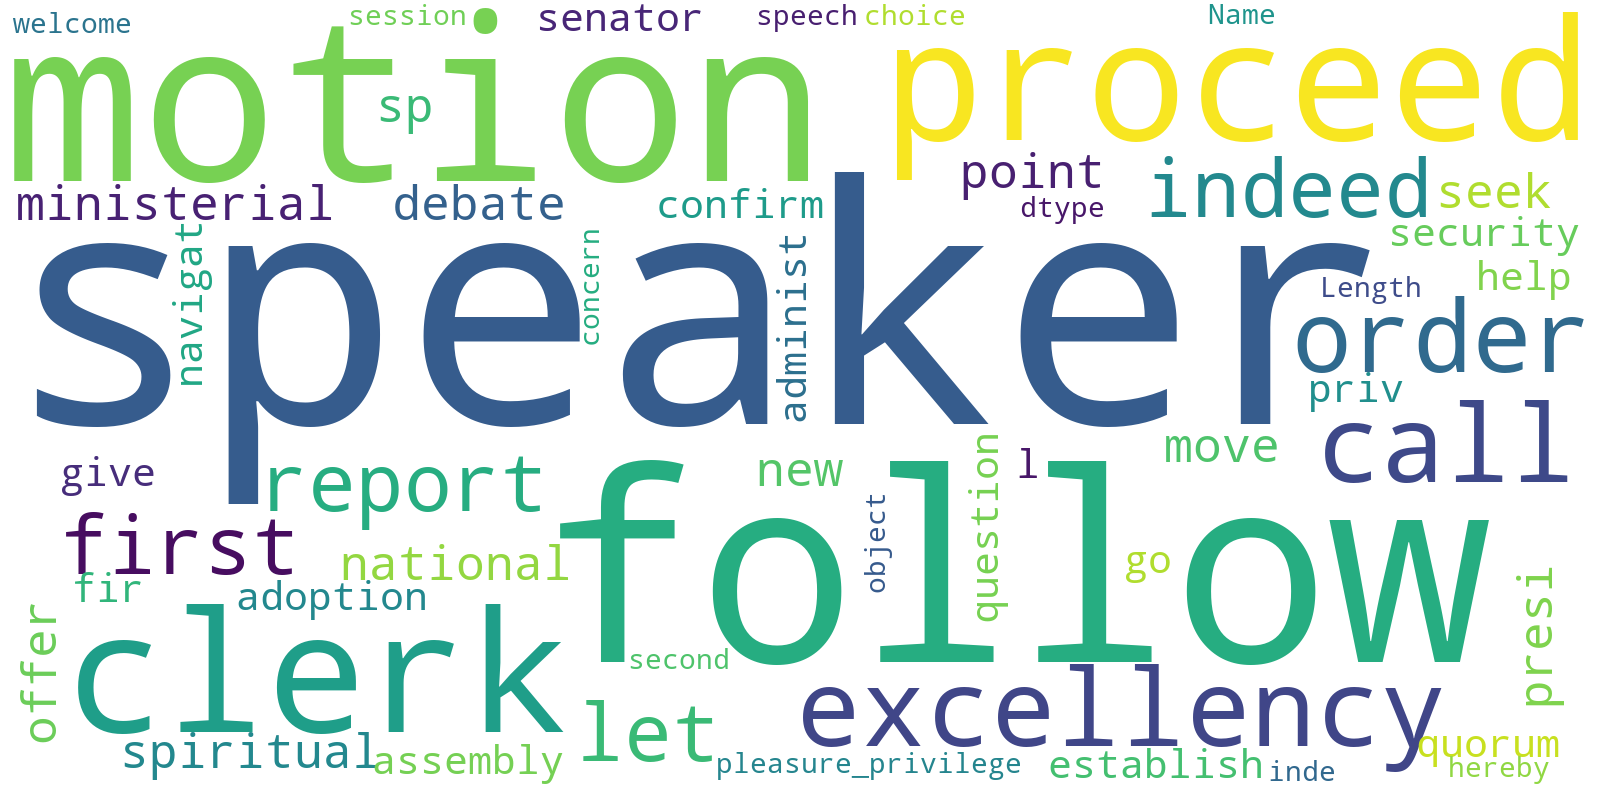

In [118]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',scale=4)
# Join the different processed titles together.
long_string = str(df2.speech.swifter.apply(",".join))
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [119]:
id2word.save('id2word_v2.dict')

In [120]:
# from gensim.corpora.mmcorpus import MmCorpus
# from gensim.test.utils import datapath

# corpus = MmCorpus(datapath('test_mmcorpus_with_index.mm'))

In [121]:
from gensim.corpora import MmCorpus
from gensim.test.utils import get_tmpfile

output_fname = get_tmpfile("corpus_v1.mm")

MmCorpus.serialize('test.pkl', corpus,metadata=True)
mm = MmCorpus('test.pkl')  # `mm` document stream now has random access
print(mm[1])  

[(6, 5.0), (7, 3.0), (8, 2.0), (15, 4.0), (17, 6.0), (23, 8.0), (44, 3.0), (46, 10.0), (47, 2.0), (50, 5.0), (55, 12.0), (60, 12.0), (96, 3.0), (99, 22.0), (134, 2.0), (135, 9.0), (136, 4.0), (148, 3.0), (163, 7.0), (196, 3.0), (219, 1.0), (220, 4.0), (223, 3.0), (231, 1.0), (232, 2.0), (234, 1.0), (237, 1.0), (239, 2.0), (244, 1.0), (247, 1.0), (248, 2.0), (250, 2.0), (253, 2.0), (255, 4.0), (264, 1.0), (266, 1.0), (268, 2.0), (269, 2.0), (271, 1.0), (276, 2.0), (278, 2.0), (281, 1.0), (286, 4.0), (287, 1.0), (289, 2.0), (290, 1.0), (292, 1.0), (298, 1.0), (304, 2.0), (309, 14.0), (315, 3.0), (328, 1.0), (333, 1.0), (339, 1.0), (341, 2.0), (343, 1.0), (344, 1.0), (349, 2.0), (350, 1.0), (354, 2.0), (355, 1.0), (357, 1.0), (358, 2.0), (360, 1.0), (361, 3.0), (362, 3.0), (369, 1.0), (372, 2.0), (373, 2.0), (383, 4.0), (385, 1.0), (386, 1.0), (387, 1.0), (388, 2.0), (390, 4.0), (396, 1.0), (398, 1.0), (400, 1.0), (401, 1.0), (403, 2.0), (405, 1.0), (410, 1.0), (411, 2.0), (414, 1.0), (41

# Modelling with LDA

In [122]:
 def compute_coherence_values(dictionary, corpus,limit=80, start=2, step=2):
    """
    Compute u_mass coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"number of topics: {num_topics}")
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=1000,
                                           chunksize=50,
                                           passes=30,
                                           workers=7)
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model,corpus=corpus, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [123]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, start=2, limit=80, step=2)

number of topics: 2
number of topics: 4
number of topics: 6
number of topics: 8
number of topics: 10
number of topics: 12
number of topics: 14
number of topics: 16
number of topics: 18
number of topics: 20
number of topics: 22
number of topics: 24
number of topics: 26
number of topics: 28
number of topics: 30
number of topics: 32
number of topics: 34
number of topics: 36
number of topics: 38
number of topics: 40
number of topics: 42
number of topics: 44
number of topics: 46
number of topics: 48
number of topics: 50
number of topics: 52
number of topics: 54
number of topics: 56
number of topics: 58
number of topics: 60
number of topics: 62
number of topics: 64
number of topics: 66
number of topics: 68
number of topics: 70
number of topics: 72
number of topics: 74
number of topics: 76
number of topics: 78


There are `78` model generated based on the number of topics.The 

## Plot the coherences values against the number of topics

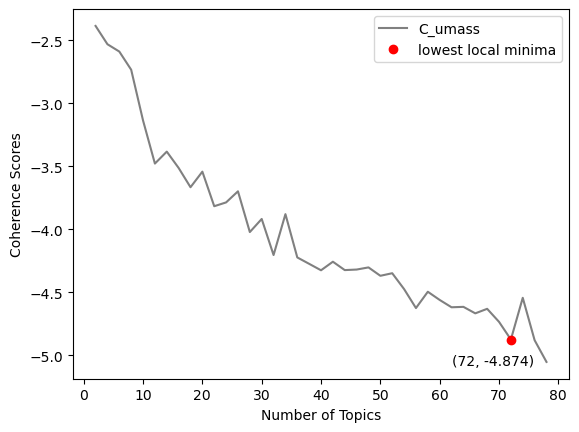

In [193]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

series = np.array(coherence_values)

# Find the local minimas in the code
mins, _ =find_peaks(series*-1)

# Show graph
# 'x' represents the number of topics
limit=80; start=2; step=2;
x = np.arange(start, limit, step)

lowest_local_minima_index = max(mins)

# coherence value based on the lowest local minima
lowest_score = coherence_values[lowest_local_minima_index]
num_of_topics = x[lowest_local_minima_index]

plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.plot(x, series, color='grey',label='C_umass');
plt.plot(x[lowest_local_minima_index], series[lowest_local_minima_index], 'o', color='red',
         label='lowest local minima')


# Annotation
plt.annotate(f'{(num_of_topics,round(lowest_score,3))}', xy =(num_of_topics,lowest_score),
                xytext =(num_of_topics-10, lowest_score-0.2))

# Add a label to the line indicating the lowest score
plt.legend()
plt.show()

In [206]:
# pd.DataFrame(x,coherence_values)
import pandas as pdf
d = {'Number of topics': x, 'Coherence_values':coherence_values}
models= pdf.DataFrame(d)
models.to_csv("model_training_output.csv",index=False)

In [126]:
# df_count = df2.groupby([df2.session_date.dt.year,df2.session_date.dt.month],as_index=False)['chamber'].agg({'count'}).reset_index(drop=True).to_numpy().tolist()

# time_slice=[item[0] for item in df_count]

In [127]:
# from gensim.test.utils import common_corpus
# from gensim.models import LdaSeqModel


# ldaseq = LdaSeqModel(corpus=corpus,id2word=id2word, time_slice=time_slice, num_topics=10, chunksize=1)

In [128]:
# ldaseq.save('model/dtmmodev1')

In [129]:
best_model = model_list[lowest_local_minima_index]
best_model.save('model/bestmodel_v4')

In [130]:
#Calculate and return per-word likelihood bound, using a chunk of documents as evaluation corpus.
best_model.log_perplexity(corpus, total_docs=None)

-9.101688517564433

In [131]:
best_model.show_topics(formatted=False)[0:2]

[(0,
  [('electoral', 0.06893408),
   ('miscellaneous', 0.06612189),
   ('statute', 0.06118456),
   ('library', 0.024704153),
   ('independent_electoral', 0.017479768),
   ('voter', 0.014842815),
   ('credible', 0.014140608),
   ('nomination', 0.01363841),
   ('polling', 0.013471864),
   ('polling_station', 0.01208877)]),
 (38,
  [('attorney', 0.03423824),
   ('sanitary', 0.03361626),
   ('attorney_general', 0.015591472),
   ('distinguished_senator', 0.014719687),
   ('girl', 0.012129123),
   ('teenage', 0.0114654),
   ('gender_equality', 0.011044398),
   ('equality', 0.008647297),
   ('partnership', 0.00862328),
   ('empowerment', 0.007195747)])]

In [132]:
best_model.top_topics(corpus,dictionary=id2word,topn=10)[0:2]

[([(0.17550658, 'subclause'),
   (0.05081841, 'delete'),
   (0.038535897, 'deletion'),
   (0.027467873, 'substitute'),
   (0.02395243, 'paragraph_substitute_therefor'),
   (0.020106092, 'justification'),
   (0.018485077, 'clause_substitute_therefor'),
   (0.017952507, 'subclause_substitute_therefor'),
   (0.014520314, 'substitute_therefor'),
   (0.012675913, 'insert')],
  -1.3283307282388295),
 ([(0.063235685, 'nuclear'),
   (0.05825989, 'geothermal'),
   (0.034487955, 'nuclear_energy'),
   (0.030808074, 'rural_electrification'),
   (0.026620816, 'solar'),
   (0.023782952, 'renewable_energy'),
   (0.018271672, 'coal'),
   (0.014941116, 'solar_energy'),
   (0.012553649, 'oil'),
   (0.01232812, 'connection')],
  -1.5962537684551055)]

In [133]:
a = best_model.top_topics(corpus,dictionary=id2word,topn=10)[0:4]

final=[]

count=0
for topic in a:
    rev_topics= [tuple(reversed(item)) for item in topic[0]]
    
    final.append((count,rev_topics))

In [134]:
final[1]

(0,
 [('nuclear', 0.063235685),
  ('geothermal', 0.05825989),
  ('nuclear_energy', 0.034487955),
  ('rural_electrification', 0.030808074),
  ('solar', 0.026620816),
  ('renewable_energy', 0.023782952),
  ('coal', 0.018271672),
  ('solar_energy', 0.014941116),
  ('oil', 0.012553649),
  ('connection', 0.01232812)])

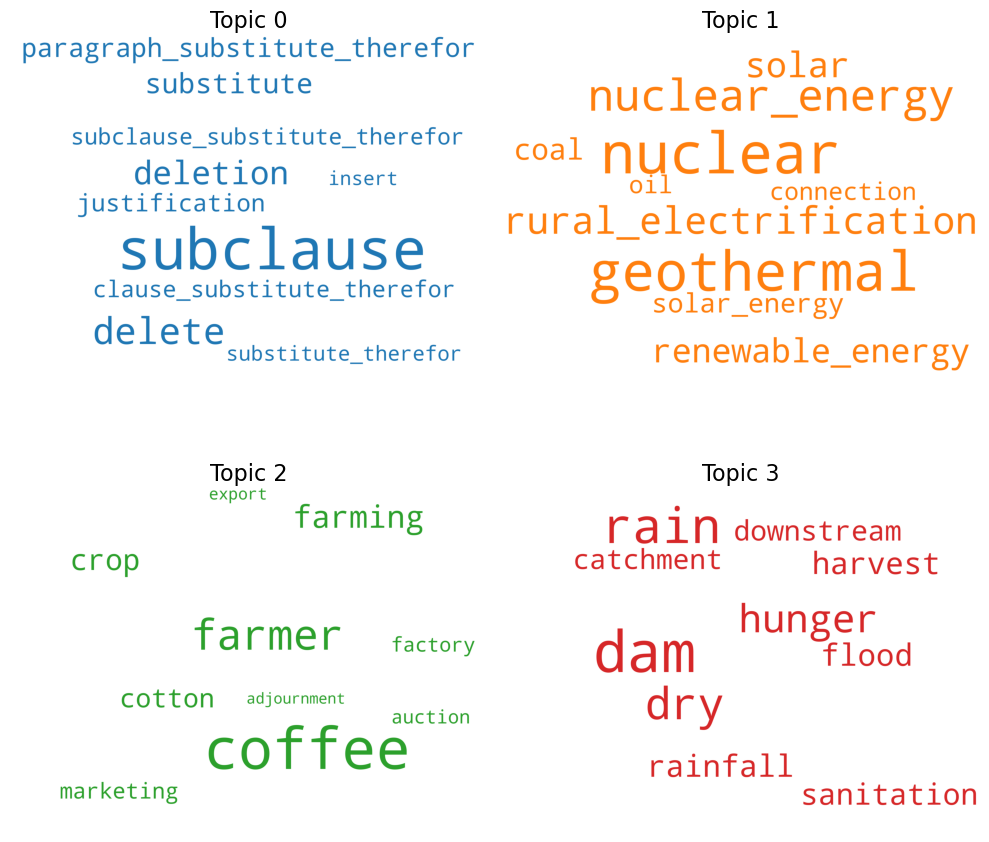

In [135]:
#Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = final

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [207]:
save_model= gensim.models.ldamodel.LdaModel.load("model/bestmodel_v3")

In [137]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(save_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
24     0.054310  0.408830       1        1  3.727974
2     -0.015774 -0.007332       2        1  3.687821
33    -0.012722  0.203281       3        1  3.630437
7     -0.118032  0.420202       4        1  3.542660
25     0.508720 -0.019688       5        1  3.493335
57     0.238319  0.081199       6        1  3.105975
22     0.021266  0.471779       7        1  2.486382
49    -0.421622 -0.239615       8        1  2.414617
36    -0.265211  0.181888       9        1  2.337284
37     0.260087  0.409126      10        1  2.202592
50     0.378679  0.215400      11        1  2.182179
42    -0.204517  0.422112      12        1  2.135136
46    -0.396137  0.136575      13        1  2.079783
9     -0.233303  0.282872      14        1  2.013095
3     -0.112482 -0.450409      15        1  2.007055
5     -0.133178  0.259207      16        1  1.966713
34    -0.244678 -0.032256      17        1  1.942063
28    -0.509251  0.037420      18        1  1.929082
0      0.202586  0.353837      19        1  1.873371
8      0.294853  0.139764      20        1  1.858204
4     -0.476596 -0.128837      21        1  1.828687
53     0.140014 -0.475350      22        1  1.679852
51     0.371443  0.336994      23        1  1.643374
54    -0.231936 -0.168227      24        1  1.634051
56    -0.369237 -0.175924      25        1  1.604400
39     0.216492 -0.017246      26        1  1.589682
45     0.427151 -0.156899      27        1  1.553619
59    -0.296124 -0.279780      28        1  1.524926
52     0.094131 -0.085275      29        1  1.491751
30    -0.000946 -0.398048      30        1  1.458542
12    -0.308022 -0.360919      31        1  1.429839
1      0.054184 -0.298432      32        1  1.371813
26    -0.432232 -0.034914      33        1  1.366793
31     0.350441 -0.323589      34        1  1.363696
29     0.277319 -0.231650      35        1  1.359355
27     0.408473 -0.061912      36        1  1.312153
15     0.463615  0.144757      37        1  1.236212
38     0.161395 -0.228676      38        1  1.227196
43    -0.114288 -0.271436      39        1  1.186144
20    -0.211990 -0.375631      40        1  1.156800
40    -0.359887  0.036158      41        1  1.152880
58    -0.446546  0.206261      42        1  1.146198
41    -0.009151 -0.166863      43        1  1.144844
11    -0.150346 -0.477862      44        1  1.133873
21     0.078727  0.259721      45        1  1.097965
35    -0.078289  0.105806      46        1  1.097007
10    -0.399218  0.314826      47        1  1.093199
18    -0.131319 -0.134757      48        1  1.085065
23     0.041520 -0.487621      49        1  1.066469
14     0.193410 -0.395594      50        1  1.058796
48     0.273406 -0.391584      51        1  1.052150
44     0.150110  0.459032      52        1  1.024067
6     -0.209134  0.080497      53        1  1.022077
13     0.137184  0.151776      54        1  0.982031
19    -0.287129  0.394566      55        1  0.978415
16    -0.048915  0.397624      56        1  0.948469
32     0.435583 -0.254734      57        1  0.935809
47     0.304612 -0.109977      58        1  0.801850
17     0.400456  0.063345      59        1  0.797611
55     0.289726  0.266181      60        1  0.746579, topic_info=                   Term         Freq        Total Category  logprob  loglift
5232          subclause  6011.000000  6011.000000  Default  30.0000  30.0000
5640             cancer  4071.000000  4071.000000  Default  29.0000  29.0000
23               coffee  2860.000000  2860.000000  Default  28.0000  28.0000
14227  division_revenue  2730.000000  2730.000000  Default  27.0000  27.0000
80                 fuel  2301.000000  2301.000000  Default  26.0000  26.0000
...                 ...          ...          ...      ...      ...      ...
1517       substantiate    45.022145   942.642568  Topic60  -5.0225   1.8559
1856     identification    37.584653   619.660371  Topi

# Offline Visualisation

This section load saved corpus, dictionary and model. The pyLDAvis requires corpus and dictionary to show visualisation.

## Load corpus, dictionary and model

In [212]:
import gensim.corpora as corpora

saved_dict   = corpora.Dictionary.load('id2word_v2.dict')
saved_corpus  = corpora.MmCorpus('test.pkl')
saved_model   = gensim.models.ldamodel.LdaModel.load("model/bestmodel_v3")

## Plot topics

In [213]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(saved_model, saved_corpus, saved_dict, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
24     0.054310  0.408830       1        1  3.727974
2     -0.015774 -0.007332       2        1  3.687821
33    -0.012722  0.203281       3        1  3.630437
7     -0.118032  0.420202       4        1  3.542660
25     0.508720 -0.019688       5        1  3.493335
57     0.238319  0.081199       6        1  3.105975
22     0.021266  0.471779       7        1  2.486382
49    -0.421622 -0.239615       8        1  2.414617
36    -0.265211  0.181888       9        1  2.337284
37     0.260087  0.409126      10        1  2.202592
50     0.378679  0.215400      11        1  2.182179
42    -0.204517  0.422112      12        1  2.135136
46    -0.396137  0.136575      13        1  2.079783
9     -0.233303  0.282872      14        1  2.013095
3     -0.112482 -0.450409      15        1  2.007055
5     -0.133178  0.259207      16        1  1.966713
34    -0.244678 -0.032256      17        1  1.942063
28    -0.509251  0.037420      18        1  1.929082
0      0.202586  0.353837      19        1  1.873371
8      0.294853  0.139764      20        1  1.858204
4     -0.476596 -0.128837      21        1  1.828687
53     0.140014 -0.475350      22        1  1.679852
51     0.371443  0.336994      23        1  1.643374
54    -0.231936 -0.168227      24        1  1.634051
56    -0.369237 -0.175924      25        1  1.604400
39     0.216492 -0.017246      26        1  1.589682
45     0.427151 -0.156899      27        1  1.553619
59    -0.296124 -0.279780      28        1  1.524926
52     0.094131 -0.085275      29        1  1.491751
30    -0.000946 -0.398048      30        1  1.458542
12    -0.308022 -0.360919      31        1  1.429839
1      0.054184 -0.298432      32        1  1.371813
26    -0.432232 -0.034914      33        1  1.366793
31     0.350441 -0.323589      34        1  1.363696
29     0.277319 -0.231650      35        1  1.359355
27     0.408473 -0.061912      36        1  1.312153
15     0.463615  0.144757      37        1  1.236212
38     0.161395 -0.228676      38        1  1.227196
43    -0.114288 -0.271436      39        1  1.186144
20    -0.211990 -0.375631      40        1  1.156800
40    -0.359887  0.036158      41        1  1.152880
58    -0.446546  0.206261      42        1  1.146198
41    -0.009151 -0.166863      43        1  1.144844
11    -0.150346 -0.477862      44        1  1.133873
21     0.078727  0.259721      45        1  1.097965
35    -0.078289  0.105806      46        1  1.097007
10    -0.399218  0.314826      47        1  1.093199
18    -0.131319 -0.134757      48        1  1.085065
23     0.041520 -0.487621      49        1  1.066469
14     0.193410 -0.395594      50        1  1.058796
48     0.273406 -0.391584      51        1  1.052150
44     0.150110  0.459032      52        1  1.024067
6     -0.209134  0.080497      53        1  1.022077
13     0.137184  0.151776      54        1  0.982031
19    -0.287129  0.394566      55        1  0.978415
16    -0.048915  0.397624      56        1  0.948469
32     0.435583 -0.254734      57        1  0.935809
47     0.304612 -0.109977      58        1  0.801850
17     0.400456  0.063345      59        1  0.797611
55     0.289726  0.266181      60        1  0.746579, topic_info=                   Term         Freq        Total Category  logprob  loglift
5232          subclause  6011.000000  6011.000000  Default  30.0000  30.0000
5640             cancer  4071.000000  4071.000000  Default  29.0000  29.0000
23               coffee  2860.000000  2860.000000  Default  28.0000  28.0000
14227  division_revenue  2730.000000  2730.000000  Default  27.0000  27.0000
80                 fuel  2301.000000  2301.000000  Default  26.0000  26.0000
...                 ...          ...          ...      ...      ...      ...
1517       substantiate    45.022145   942.642568  Topic60  -5.0225   1.8559
1856     identification    37.584653   619.660371  Topi

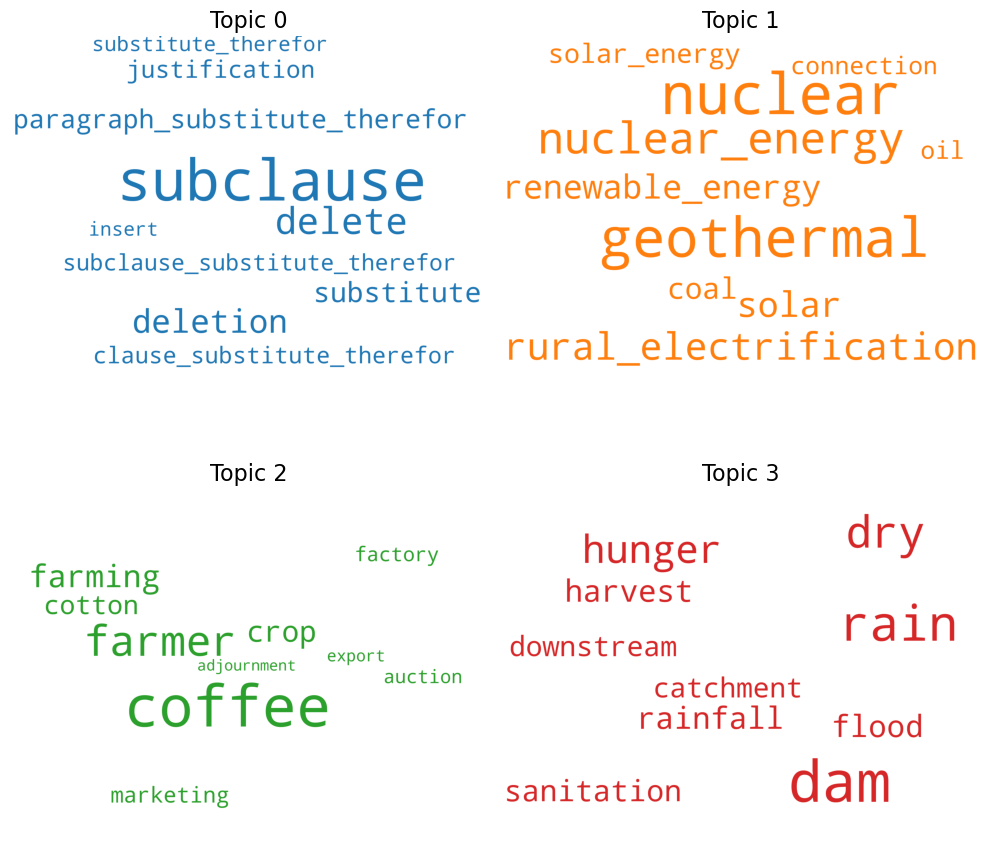

In [222]:
b = saved_model.top_topics(corpus,dictionary=id2word,topn=10)[0:4]

final=[]

for topic in a:
    rev_topics= [tuple(reversed(item)) for item in topic[0]]
    
    final.append((count,rev_topics))





# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = final

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()